# Preable

This is a technical attempt to form a couple of models and compare their performance.

### I think running SageMaker AutoPilot on the hyper parameters would create a greatly improved model(s)

There are at least 3 problems with this notebook:

* 1.  I leave the "P" columns in though I don't use them
* 2.  Cell 10 drops the City column and I'm not sure this is a valid idea.
* 3.  The outliers in the revenue column are dropped

Improvements we should make:

* Inspect and understand the outliers in the revenue column
* Create an executive summary, with results neatly tabulated
* Make a predictor cell
* Show how to feed a data tupple into this predictor

### How to read this:

find the cell "Modeling starts here" and read from there

In [1]:
!pip install phik

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

import phik
from sklearn.preprocessing import LabelEncoder


In [3]:
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('./test_data.csv')
train_df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,4244605.96
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,3287351.70
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,4219403.66
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,3.0,0,4,0,0,0,0,0,0,3937158.64
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,5877728.96


In [4]:
# transform the 'Open Date' feature
def newFeatures_train(df):
  df['Date'] = pd.to_datetime(df['Open Date'],format="%m/%d/%Y")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
  df = df.drop(['Open Date','Date'],axis=1)
  return df

In [5]:
# transform the 'Open Date' feature
def newFeatures_test(df):
  df['Date'] = pd.to_datetime(df['Open Date'],format="%m/%d/%y")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
  df = df.drop(['Open Date','Date'],axis=1)
  return df

In [6]:
#Reordering columns
def reorderingCols(train_data,test_data):
    train = train_data[['Id','City','City Group','Type','Year','Month','Years Old','P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P22','P23','P24','P25','P26','P27','P28','P29','P30','P31','P32','P33','P34','P35','P36','P37','revenue']]
    test = test_data[['Id','City','City Group','Type','Year','Month','Years Old','P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P22','P23','P24','P25','P26','P27','P28','P29','P30','P31','P32','P33','P34','P35','P36','P37']]
    return train,test

In [7]:
#Even after logarithmic transformation of 'revenue' variable still there exists skewness. So lets drop few outliers.
def handlingOutliers(train):
  train = train[train['revenue']<train['revenue'].quantile(0.98)] 
  return train

In [8]:
def numFea(train_data):
    #To find highly correlated independent features.
    num_fea = train_data.drop(['Id','revenue','City Group','Type'],axis=1)
    corr = train_data.corr()
    #https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python
    upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))  #numerical features that are highly correlated with each other
    corr_col = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

    Phi_corr = train_data.drop(['Id'],axis=1).phik_matrix()
    fea = train_data.drop(['Id','revenue'],axis=1)
    Phi_corrFea = (Phi_corr['revenue'].sort_values(ascending=False)==0) #Features that have zero or no correlation with target variable
    no_cor = [col for col in fea.columns if Phi_corrFea[col]==True]

    drop_num = [col for col in corr_col if col not in no_cor]  #Dropping Features that are having zero correlation with the target variable but are highly correlated with other variables  
    return drop_num

In [9]:
def catFea(df):
  labelEncoding = LabelEncoder()
  df['City Group'] = labelEncoding.fit_transform(df['City Group'].astype('str'))
  df['Type'] = labelEncoding.fit_transform(df['Type'].astype('str'))
  return df

In [10]:
#City can be dropped because there are 23 cities in test that are unseen during training phase
def split_X_y(train_data,test_data):
    y_train = train_data['revenue']
    X_train = train_data.drop(['Id','revenue','City'],axis=1)
    X_test = test_data.drop(['Id','City'],axis=1)
    return X_train,X_test,y_train

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
def scaling(X_train,X_test):
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)
    return X_train_scale,X_test_scale

In [12]:
from sklearn.decomposition import PCA
#https://www.geeksforgeeks.org/principal-component-analysis-with-python/
def principalComponentAnalysis(X_train,X_test):
    pca = PCA(n_components = 10)
    X_train_PCA = pca.fit_transform(X_train) 
    X_test_PCA = pca.transform(X_test) 
    return X_train_PCA,X_test_PCA


In [13]:
def featureEngineering(train,test):

    #generating new features
    train = newFeatures_train(train)
    test = newFeatures_test(test)
    
    #Reordering columns
    train,test = reorderingCols(train,test)
    

    #Handling numerical features
    dropnum = numFea(train)
    train  = train.drop(dropnum,axis=1)
    test = test.drop(dropnum,axis=1)
    print(dropnum)

    #Handling outliers
    train = handlingOutliers(train)

    #Handling categorical features
    train = catFea(train) 
    test = catFea(test) 
   

    #Split X & y
    X_train,X_test,y_train = split_X_y(train,test)
    print(X_train.columns)
    print(X_test.columns)

    #Standard Scaling
    X_train_scale,X_test_scale = scaling(X_train,X_test)

    #Principal Component Analysis
    X_train_PCA,X_test_PCA = principalComponentAnalysis(X_train,X_test)

    return X_train,X_test,X_train_scale,X_test_scale, X_train_PCA,X_test_PCA,y_train

In [14]:
X_train,X_test,X_train_scale,X_test_scale, X_train_PCA,X_test_PCA,y_train = featureEngineering(train_df,test_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


interval columns not set, guessing: ['Year', 'Month', 'Years Old', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue']
[]
Index(['City Group', 'Type', 'Year', 'Month', 'Years Old', 'P1', 'P2', 'P3',
       'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14',
       'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24',
       'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34',
       'P35', 'P36', 'P37'],
      dtype='object')
Index(['City Group', 'Type', 'Year', 'Month', 'Years Old', 'P1', 'P2', 'P3',
       'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14',
       'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24',
       'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34',


In [15]:
X_train.head(2)

,City Group,Type,Year,Month,Years Old,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,1,1,2011,1,4,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,2,2011,3,4,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0


In [16]:
X_test.head(2)

,City Group,Type,Year,Month,Years Old,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,2,1999,7,16,4,5.0,4.0,4.0,2,...,2.0,3.0,5,3,4,5,5,4,3,4
1,0,1,2008,2,7,4,5.0,4.0,4.0,1,...,3.0,3.0,0,0,0,0,0,0,0,0


In [17]:
print(X_train.shape,' ',X_test.shape)

(97715, 42)   (137, 42)


# =====================
# Modeling starts here
# =====================

In [21]:
from sklearn import linear_model
model_LR1 = linear_model.LassoCV(max_iter=10000,alphas=(0.0001,0.01,0.1,1),n_alphas=(100,300,500,1000),cv=5)

lassoCV = model_LR1.fit(X_train_scale,y_train)
y_pred = model_LR1.predict(X_train_scale)
LR_rmse = mean_squared_error(y_train, y_pred, squared=False)
print('Train LassoCV RMSE            score :',LR_rmse)

model_LR1.fit(X_train_PCA,y_train)
y_pred_PCA = model_LR1.predict(X_train_PCA)
LR_rmse_PCA = mean_squared_error(y_train, y_pred_PCA, squared=False)
print('Train LassoCV (with PCA) RMSE score :',LR_rmse_PCA)



Train LassoCV RMSE            score : 789663.1218025794
Train LassoCV (with PCA) RMSE score : 964087.3786891912


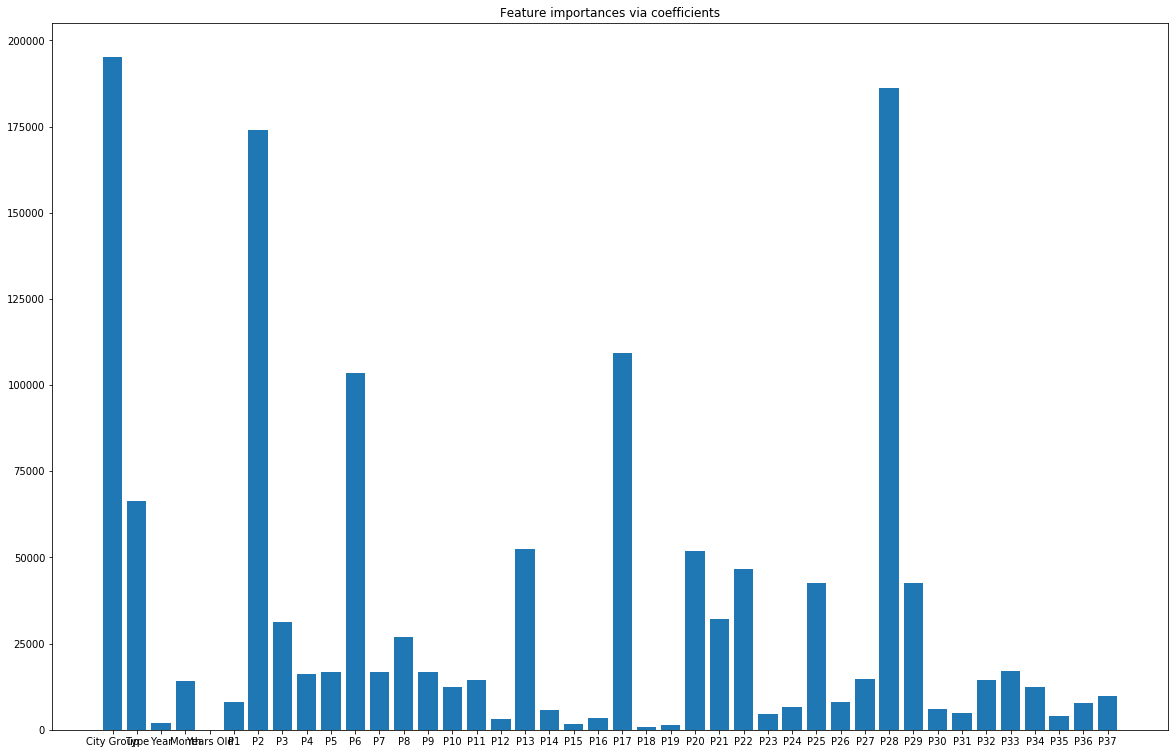

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV


lasso = lassoCV.fit(X_train, y_train)
importance = np.abs(lasso.coef_)
feature_names = np.array(X_train.columns)

plt.figure(figsize=(20,13))
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [19]:
from sklearn.linear_model import RidgeCV
model_RR1 = RidgeCV(alphas=(0.0001,0.01,0.1,1,10),cv=5)

model_RR1.fit(X_train_scale,y_train)
y_pred = model_RR1.predict(X_train_scale)
RR_rmse = mean_squared_error(y_train, y_pred, squared=False)
print('Train RMSE       score :',RR_rmse)


model_RR1.fit(X_train_PCA,y_train)
y_pred = model_RR1.predict(X_train_PCA)
RR_rmse_PCA = mean_squared_error(y_train, y_pred, squared=False)
print('Train RMSE (PCA) score :',RR_rmse_PCA)



Train RMSE       score : 789663.1258331359
Train RMSE (PCA) score : 964087.3786910219


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": randint(10,1000),
    "max_depth": randint(1,10),
    "min_samples_split": uniform(0.1,0.8),
    'max_features':['auto', 'sqrt', 'log2']
}

RF_model = RandomForestRegressor()
model_rf1 = RandomizedSearchCV(RF_model, params, cv=5, n_iter=25, scoring='neg_mean_squared_error', return_train_score=True, verbose=3, n_jobs=-1)

model_rf1.fit(X_train_scale, y_train)
y_pred_rf = model_rf1.predict(X_train_scale)
RF_rmse_sc = mean_squared_error(y_train, y_pred_rf, squared=False)
print('Train RMSE score :',RF_rmse_sc)


model_rf1.fit(X_train_PCA, y_train)
y_pred_rf = model_rf1.predict(X_train_PCA)
RF_rmse_pca = mean_squared_error(y_train, y_pred_rf, squared=False)
print('Train RMSE score :',RF_rmse_pca)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 28.6min finished


Train RMSE score : 672929.8381677278
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
col_names = X_train.columns
importances = model_rf1.best_estimator_.feature_importances_
idxs = np.argsort(importances)
plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)),[col_names[i] for i in idxs])
plt.xlabel('Features')
plt.show()